## Problem 1

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import t, norm
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
dat = pd.read_csv('problem1.csv')

In [10]:
def var_normal(returns, significance_level=0.05, num_samples=10000):
    # Calculate the mean and standard deviation of the returns
    mean_return = returns.mean()
    std_return = returns.std()
    
    # Generate random samples from a normal distribution based on the historical mean and std deviation
    simulated_returns = np.random.normal(mean_return, std_return, num_samples)
    
    # Sort the simulated returns in ascending order
    simulated_returns.sort()
    
    # Compute the Value-at-Risk (VaR) at the given significance level
    VaR = -simulated_returns[int(significance_level * len(simulated_returns))]
    
    return VaR, simulated_returns

def var_t(returns, significance_level=0.05, num_samples=10000):
    # Fit the returns to a t-distribution using MLE
    df, loc, scale = t.fit(returns, method="MLE")
    
    # Generate random samples from the fitted t-distribution
    simulated_returns = t.rvs(df, loc, scale, size=num_samples)
    
    # Sort the simulated returns in ascending order
    simulated_returns.sort()
    
    # Compute the Value-at-Risk (VaR) at the given significance level
    VaR = -simulated_returns[int(significance_level * len(simulated_returns))]
    
    return VaR, simulated_returns

def calculate_es(var, sim_data):
    return -np.mean(sim_data[sim_data <= -var])


In [34]:
var_normal_value, simulated_data_normal = var_normal(dat['x'])
es_normal = calculate_es(var_normal_value, simulated_data_normal)

var_t_value, simulated_data_t = var_t(dat['x'])
es_t = calculate_es(var_t_value, simulated_data_t)

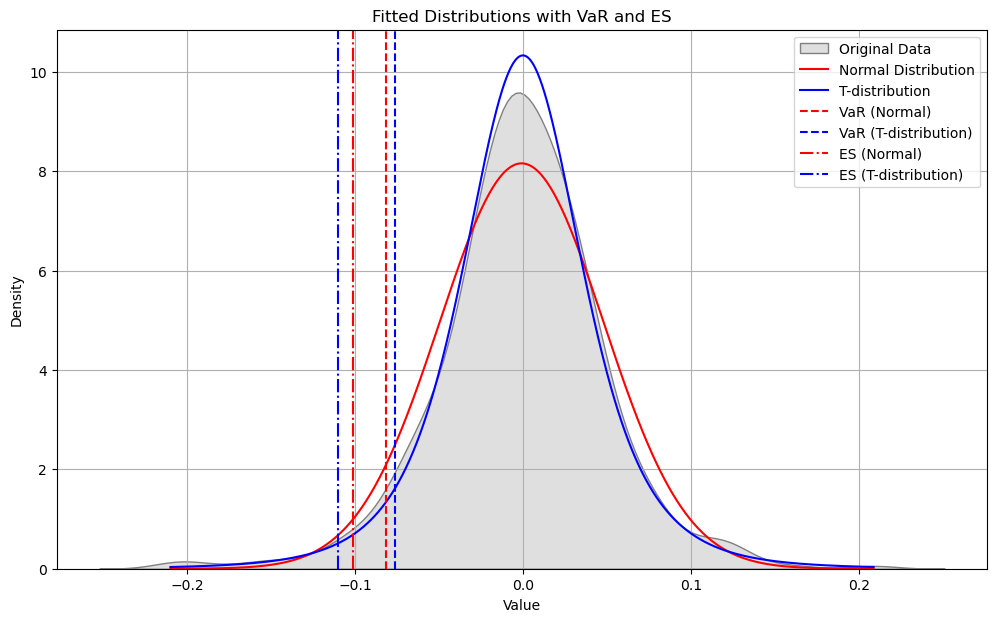

,Distribution,VaR,ES
0,Normal,0.081291,0.101211
1,t-distribution,0.076077,0.110099


In [35]:
table_data = {
    'Distribution': ['Normal', 't-distribution'],
    'VaR': [var_normal_value, var_t_value],
    'ES': [es_normal, es_t]
}
table_df = pd.DataFrame(table_data)

# Plotting the distribution PDFs, VaR, and ES values
x_values = np.linspace(min(dat['x']), max(dat['x']), 1000)
pdf_normal = norm.pdf(x_values, dat['x'].mean(), dat['x'].std())
pdf_t = t.pdf(x_values, *t.fit(dat['x'], method="MLE"))

# Plotting
plt.figure(figsize=(12, 7))
sns.kdeplot(dat['x'], fill=True, label='Original Data', color='grey')
plt.plot(x_values, pdf_normal, 'r-', label='Normal Distribution')
plt.plot(x_values, pdf_t, 'b-', label='T-distribution')
plt.axvline(-var_normal_value, color='r', linestyle='--', label='VaR (Normal)')
plt.axvline(-var_t_value, color='b', linestyle='--', label='VaR (T-distribution)')
plt.axvline(-es_normal, color='r', linestyle='-.', label='ES (Normal)')
plt.axvline(-es_t, color='b', linestyle='-.', label='ES (T-distribution)')
plt.title('Fitted Distributions with VaR and ES')
plt.legend()
plt.grid(True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

table_df

## Problem 2

In [12]:
from qrm_hj import MC, VaR

# Load data
df = pd.read_csv("DailyPrices.csv")
portfolio = pd.read_csv('portfolio.csv')
prices = pd.read_csv('DailyPrices.csv')

# Test the return calculation
all_returns = VaR.return_calculate(df)
all_returns.drop('Date', axis=1, inplace=True)
print(all_returns)

# Test covariance estimation
ew_cov_matrix = MC.expo_weighted_cov(all_returns, 0.97)
pearson_corr_matrix = MC.pearson_corr_with_ew_variance(all_returns)
ew_corr_matrix = MC.ew_corr_with_pearson_variance(all_returns)

print(ew_cov_matrix)
print(pearson_corr_matrix)
print(ew_corr_matrix)

# Test non-PSD fixes
sample_matrix = np.full((500, 500), 0.9)
np.fill_diagonal(sample_matrix, 1.0)
sample_matrix[0, 1] = sample_matrix[1, 0] = 0.7357
print('Original Matrix is PSD? ', MC.psd(sample_matrix))

adjusted_matrix_near = MC.near_psd(sample_matrix)
print('Adjusted (near) Matrix is PSD? ', MC.psd(adjusted_matrix_near))

# weight_matrix = np.identity(len(sample_matrix))
# adjusted_matrix_higham = MC.higham_psd(sample_matrix, weight_matrix)
# print('Adjusted (Higham) Matrix is PSD? ', MC.psd(adjusted_matrix_higham))

# Test simulation processes
normal_simulations = MC.multiv_normal_sim(ew_cov_matrix, 100)
pca_based_simulations = MC.pca_sim(ew_cov_matrix, 100, 1)
print(normal_simulations)
print(pca_based_simulations)

# Test VaR calculations for 'META'
meta_returns = all_returns['META']
print(VaR.norml_ew_var(meta_returns))
print(VaR.ar1_var(meta_returns))
print(VaR.his_var(meta_returns))

# Test portfolio VaR
portfolio_data_A, daily_prices_A, holdings_A = VaR.process_portfolio_data(portfolio, prices, 'A')
print(portfolio_data_A, daily_prices_A, holdings_A)

mc_var_A, mc_distribution_A = VaR.cal_MC_var(portfolio, prices, "A")
print(mc_var_A, mc_distribution_A)

delta_normal_var_B = VaR.cal_delta_var(portfolio, prices, "B")
print(delta_normal_var_B)

historical_var_C, historical_distribution_C = VaR.cal_his_var(portfolio, prices, "C")
print(historical_var_C, historical_distribution_C)


/home/y/yj200/.local/lib/python3.11/site-packages/qrm_hj/VaR.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[columns[i]] = adjusted_prices[:,i]
/home/y/yj200/.local/lib/python3.11/site-packages/qrm_hj/VaR.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[columns[i]] = adjusted_prices[:,i]


          SPY      AAPL      MSFT      AMZN      NVDA     GOOGL      TSLA  \
1   -0.010544 -0.013611 -0.016667 -0.002425 -0.020808 -0.017223 -0.025076   
2   -0.003773 -0.008215 -0.010974 -0.010980 -0.013336 -0.009643  0.015581   
3    0.017965  0.009254  0.019111  0.026723  0.018795  0.024717  0.033817   
4    0.006536 -0.009618  0.001666  0.002626  0.020126 -0.009776  0.019598   
5    0.015535  0.018840  0.022977  0.026575  0.028377  0.020945  0.036023   
..        ...       ...       ...       ...       ...       ...       ...   
261  0.000586  0.016913 -0.003513 -0.002920  0.001503  0.005895 -0.033201   
262 -0.002074  0.006181 -0.001246 -0.016788 -0.010144 -0.001230  0.004599   
263 -0.009193 -0.019992 -0.023977 -0.017002 -0.029435 -0.031150 -0.014672   
264 -0.016528 -0.008889 -0.003866 -0.044053 -0.028931 -0.024675 -0.026239   
265 -0.002249  0.004945 -0.007887 -0.001624  0.014457 -0.001457 -0.042315   

         GOOG     BRK-B      META  ...        CI       ETN       SLB  \
1  

## Problem 3

In [13]:
def compute_copula_var(portfolio, prices, p_type):
    p_latest_price, a_daily_prices, holdings = VaR.process_portfolio_data(portfolio, prices, p_type)
    assets_returns = VaR.return_calculate(a_daily_prices)
    assets_returns.drop('Date', axis=1, inplace=True)
    zero_mean_returns = assets_returns - assets_returns.mean()

    returns_transf = zero_mean_returns.copy()

    # Fit data with generalized T and transform to U
    for asset in returns_transf.columns.tolist():
        result = t.fit(zero_mean_returns[asset], method="MLE")
        df, loc, scale = result
        returns_transf[asset] = t.cdf(zero_mean_returns[asset], df=df, loc=loc, scale=scale)

    # Convert transformed returns to Z
    returns_transf = pd.DataFrame(norm.ppf(returns_transf), index=returns_transf.index, columns=returns_transf.columns)

    # Calculate correlation matrix
    spearman_corr_mtx = returns_transf.corr(method='spearman')

    # Simulation n draws
    simulations = MC.pca_sim(spearman_corr_mtx, 10000, percent_explain = 1)
    simulations = pd.DataFrame(simulations, columns=returns_transf.columns)

    # Convert simulations to standard normal cdf
    returns_back = pd.DataFrame(norm.cdf(simulations), index=simulations.index, columns=simulations.columns)

    # Convert cdf back to returns
    for asset in returns_transf.columns.tolist():
        result = t.fit(zero_mean_returns[asset], method="MLE")
        df, loc, scale = result
        returns_back[asset] = t.ppf(returns_back[asset], df=df, loc=loc, scale=scale)

    sim_returns = np.add(returns_back, assets_returns.mean())
    a_daily_prices = a_daily_prices.drop('Date', axis=1)
    sim_change = np.dot(sim_returns * a_daily_prices.tail(1).values.reshape(a_daily_prices.shape[1]), holdings)

    var = np.percentile(sim_change, 0.05*100) * (-1)
    es = VaR.calculate_es(var, sim_change)
    return var, es, sim_change, p_latest_price

Porfolio A
Price:  [1089316.15994]
VaR:  19742.18655994873
ES:  27699.546692216223


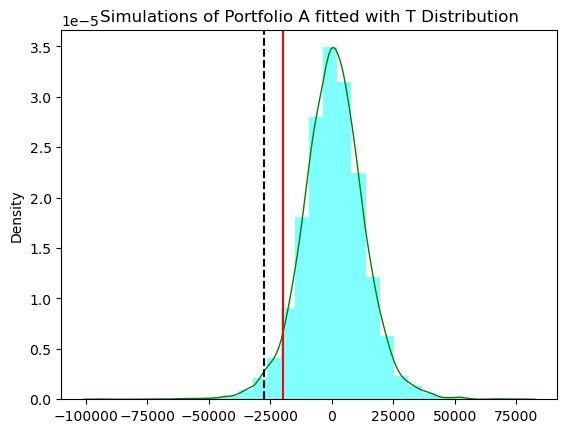

Porfolio B
Price:  [574542.40515]
VaR:  11572.827944431032
ES:  15915.441790277131


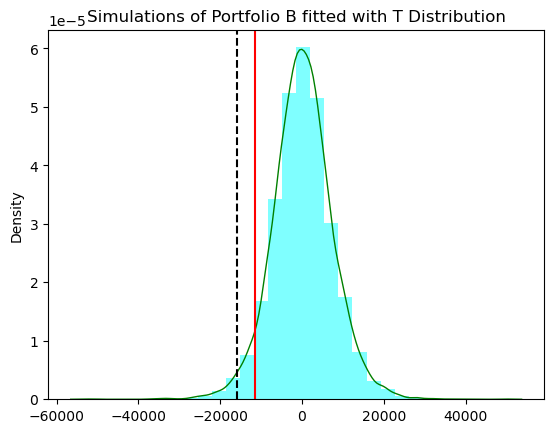

Porfolio C
Price:  [1387409.50752]
VaR:  26107.838425595623
ES:  35066.29156664601


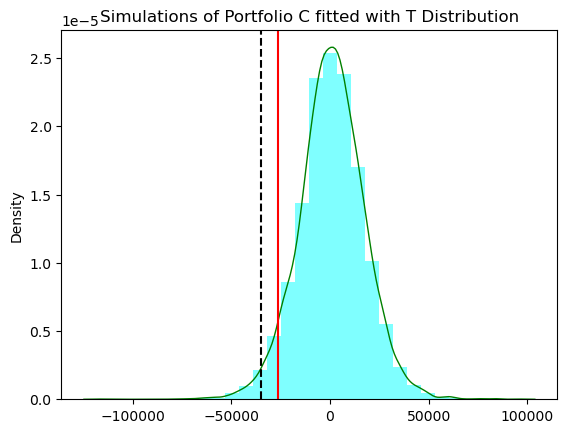

/home/y/yj200/.local/lib/python3.11/site-packages/qrm_hj/VaR.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[columns[i]] = adjusted_prices[:,i]


Porfolio TOTAL
Price:  [3051268.07261]
VaR:  54767.35397159837
ES:  73668.96059071671


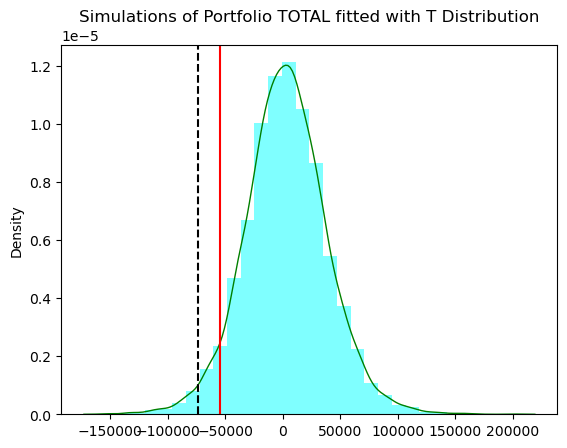

In [18]:
def plot_portfolio_results(displacements, var, es, portfolio_name):
    plt.hist(displacements, color = 'cyan', bins=30, density=True, alpha=0.5)
    sns.kdeplot(displacements, color='green', linewidth=1)
    plt.axvline(-var, label='Normal VaR', color='red', linestyle='-')
    plt.axvline(-es, label='Normal ES', color='black', linestyle='--')
    plt.ylabel('Density')
    plt.title(f'Simulations of Portfolio {portfolio_name} fitted with T Distribution')
    plt.show()

# Loading data
portfolio = pd.read_csv('portfolio.csv')
prices = pd.read_csv('DailyPrices.csv')

# Analyzing for Portfolio A
A_var, A_es, A_dis, A_p = compute_copula_var(portfolio, prices, 'A')
print('Porfolio A')
print('Price: ', A_p)
print('VaR: ', A_var)
print('ES: ', A_es)
plot_portfolio_results(A_dis, A_var, A_es, "A")

# Analyzing for Portfolio B
B_var, B_es, B_dis, B_p = compute_copula_var(portfolio, prices, 'B')
print('Porfolio B')
print('Price: ', B_p)
print('VaR: ', B_var)
print('ES: ', B_es)
plot_portfolio_results(B_dis, B_var, B_es, "B")

# Analyzing for Portfolio C
C_var, C_es, C_dis, C_p = compute_copula_var(portfolio, prices, 'C')
print('Porfolio C')
print('Price: ', C_p)
print('VaR: ', C_var)
print('ES: ', C_es)
plot_portfolio_results(C_dis, C_var, C_es, "C")

# Analyzing for Portfolio TOTAL
T_var, T_es, T_dis, T_p = compute_copula_var(portfolio, prices, 'total')
print('Porfolio TOTAL')
print('Price: ', T_p)
print('VaR: ', T_var)
print('ES: ', T_es)
plot_portfolio_results(T_dis, T_var, T_es, "TOTAL")